req         WARNING 	DEFAULT CACHE ENABLED! (24.0 KB) C:\Users\domen\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track 

Analisi sessione: Race
Pilota analizzato: VER (P6.0, Red Bull Racing)
Pilota davanti: RUS (P5.0, Mercedes)
Pilota dietro: HAM (P7.0, Mercedes)


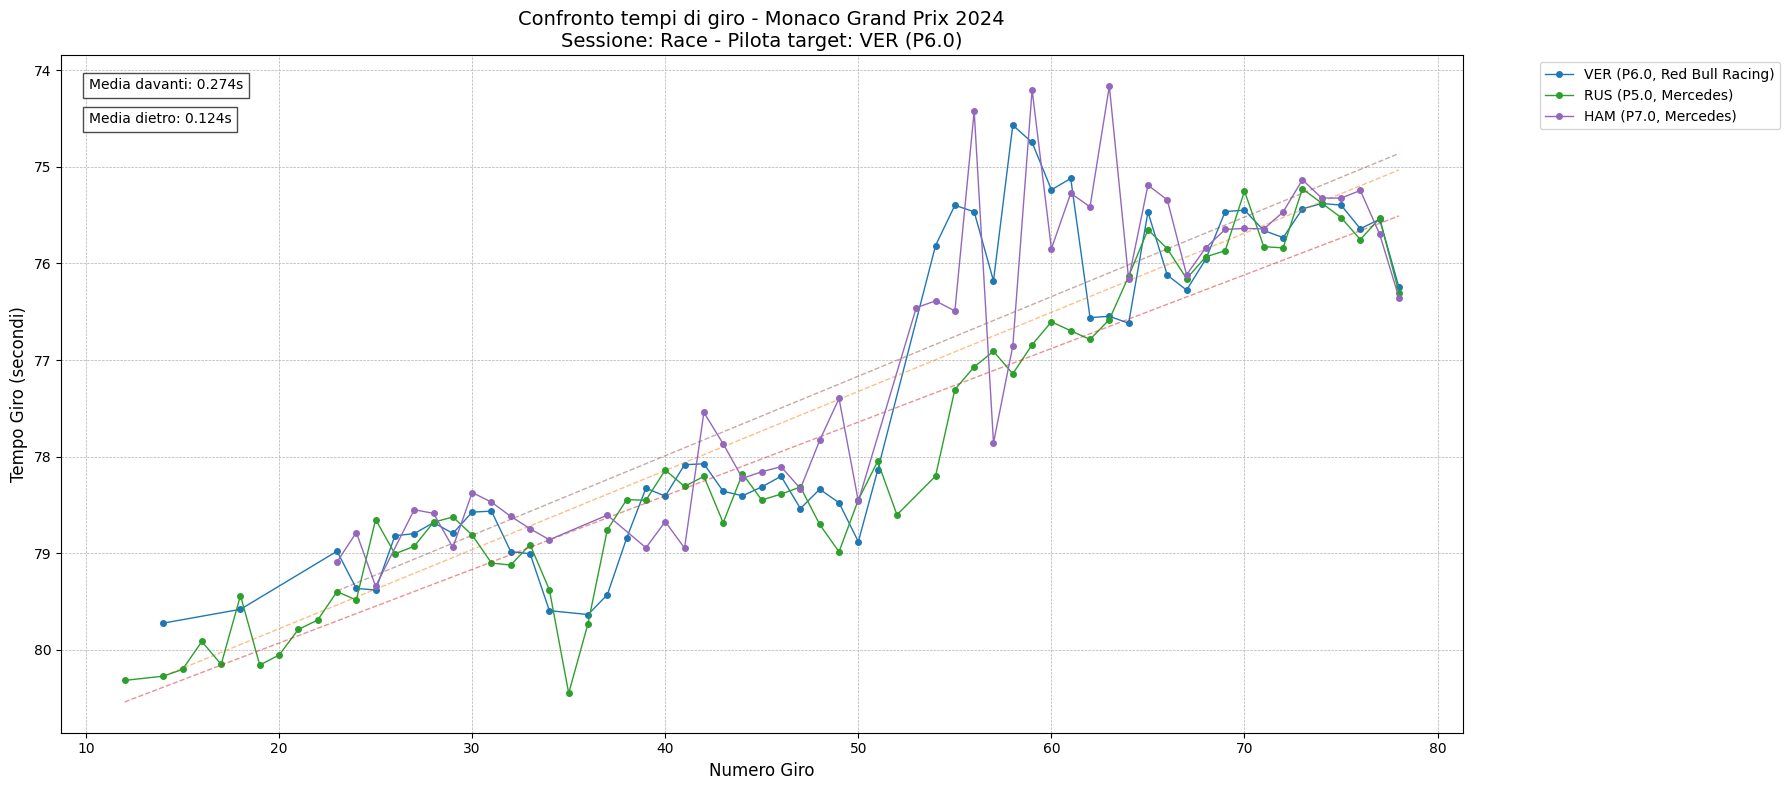

In [1]:
import fastf1
import fastf1.plotting
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

# Configurazione iniziale

fastf1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme=None, misc_mpl_mods=False)

def get_driver_data(year, event_name, session_type, driver_code):
    """
    Ottiene i dati del pilota target e dei piloti adiacenti per l'intera sessione.
    """
    # Carica la sessione
    session = fastf1.get_session(year, event_name, session_type)
    session.load()
    
    # Ottieni i risultati della gara con informazioni sulle scuderie
    results = session.results
    results = results[['Position', 'Abbreviation', 'TeamName', 'Time']].sort_values('Position')
    
    # Trova la posizione del pilota specificato
    driver_row = results[results['Abbreviation'] == driver_code].iloc[0]
    driver_pos = driver_row['Position']
    driver_team = driver_row['TeamName']
    
    # Trova i piloti adiacenti
    ahead_driver = results[results['Position'] == driver_pos - 1].iloc[0] if driver_pos > 1 else None
    behind_driver = results[results['Position'] == driver_pos + 1].iloc[0] if driver_pos < len(results) else None
    
    # Ottieni tutti i giri della sessione per i piloti interessati
    all_laps = session.laps
    
    # Filtra i giri dei piloti interessati
    driver_laps = all_laps.pick_driver(driver_code)
    ahead_laps = all_laps.pick_driver(ahead_driver['Abbreviation']) if ahead_driver is not None else None
    behind_laps = all_laps.pick_driver(behind_driver['Abbreviation']) if behind_driver is not None else None
    
    return {
        'session': session,
        'target_driver': {
            'code': driver_code,
            'position': driver_pos,
            'team': driver_team,
            'laps': driver_laps
        },
        'ahead_driver': {
            'code': ahead_driver['Abbreviation'] if ahead_driver is not None else None,
            'position': driver_pos - 1 if ahead_driver is not None else None,
            'team': ahead_driver['TeamName'] if ahead_driver is not None else None,
            'laps': ahead_laps
        },
        'behind_driver': {
            'code': behind_driver['Abbreviation'] if behind_driver is not None else None,
            'position': driver_pos + 1 if behind_driver is not None else None,
            'team': behind_driver['TeamName'] if behind_driver is not None else None,
            'laps': behind_laps
        }
    }

def plot_full_session_comparison(data):
    """
    Crea un grafico con i tempi di giro per l'intera sessione,
    mostrando il pilota target e i piloti adiacenti.
    """
    fig, ax = plt.subplots(figsize=(18, 8))
    
    # Ottieni i colori delle scuderie
    team_colors = fastf1.plotting.TEAM_COLORS
    
    # Preparazione dati per il plotting
    drivers_to_plot = [
        ('target_driver', 'Pilota Target'),
        ('ahead_driver', 'Davanti'),
        ('behind_driver', 'Dietro')
    ]
    
    # Per ogni pilota da plottare
    for driver_key, label_prefix in drivers_to_plot:
        driver_data = data.get(driver_key)  # Usiamo .get() per sicurezza
        
        if driver_data is not None and driver_data.get('laps') is not None and not driver_data['laps'].empty:
            team = driver_data.get('team')
            color = team_colors.get(team)  # Colore di default se non trovato
            
            # Estrai i tempi di giro validi
            valid_laps = driver_data['laps'].pick_quicklaps().pick_accurate()
            
            if not valid_laps.empty:
                # Crea array con il numero di giri e i tempi
                lap_numbers = valid_laps['LapNumber']
                lap_times = valid_laps['LapTime'].dt.total_seconds()
                
                # Plot dei tempi di giro
                ax.plot(lap_numbers, 
                        lap_times,
                        marker='o',
                        markersize=4,
                        linestyle='-',
                        linewidth=1,
                        color=color,
                        label=f"{driver_data.get('code')} (P{driver_data.get('position')}, {team})")
                
                # Aggiungi linea di tendenza
                z = np.polyfit(lap_numbers, lap_times, 1)
                p = np.poly1d(z)
                ax.plot(lap_numbers, p(lap_numbers), 
                        linestyle='--', 
                        linewidth=1, 
                        color=color,
                        alpha=0.5)

    # Configurazione del grafico
    ax.set_xlabel('Numero Giro', fontsize=12)
    ax.set_ylabel('Tempo Giro (secondi)', fontsize=12)
    
    session = data.get('session')
    ax.set_title(f"Confronto tempi di giro - {session.event['EventName']} {session.event.year}\n"
                f"Sessione: {session.name} - Pilota target: {data['target_driver'].get('code')} (P{data['target_driver'].get('position')})", 
                fontsize=14)
    
    ax.grid(visible=True, which='major', linestyle='--', linewidth=0.5)
    ax.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Inverti l'asse y per avere i tempi più veloci in alto
    ax.invert_yaxis()
    
    # Aggiungi differenze medie tra i piloti
    if data.get('ahead_driver', {}).get('laps') is not None and not data['ahead_driver']['laps'].empty:
        try:
            avg_diff = calculate_average_gap(data['target_driver']['laps'], data['ahead_driver']['laps'])
            ax.text(0.02, 0.95, f"Media davanti: {avg_diff.get('ahead', 'N/A'):.3f}s", 
                   transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
        except Exception as e:
            print(f"Errore nel calcolo della media davanti: {e}")
    
    if data.get('behind_driver', {}).get('laps') is not None and not data['behind_driver']['laps'].empty:
        try:
            avg_diff = calculate_average_gap(data['target_driver']['laps'], data['behind_driver']['laps'])
            ax.text(0.02, 0.90, f"Media dietro: {avg_diff.get('behind', 'N/A'):.3f}s", 
                   transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
        except Exception as e:
            print(f"Errore nel calcolo della media dietro: {e}")
    
    plt.tight_layout()
    plt.show()

def calculate_average_gap(reference_laps, compare_laps):
    """
    Calcola la differenza media tra i tempi di giro di due piloti.
    """
    try:
        ref_laps = reference_laps.pick_quicklaps().pick_accurate()
        comp_laps = compare_laps.pick_quicklaps().pick_accurate()
        
        # Trova giri in comune
        common_laps = set(ref_laps['LapNumber']).intersection(set(comp_laps['LapNumber']))
        
        if not common_laps:
            return {'ahead': None, 'behind': None}
        
        # Calcola differenze
        diffs = []
        for lap in common_laps:
            ref_time = ref_laps[ref_laps['LapNumber'] == lap]['LapTime'].iloc[0].total_seconds()
            comp_time = comp_laps[comp_laps['LapNumber'] == lap]['LapTime'].iloc[0].total_seconds()
            diffs.append(comp_time - ref_time)
        
        avg_diff = np.mean(diffs)
        
        return {'ahead': avg_diff if avg_diff > 0 else None,
                'behind': -avg_diff if avg_diff < 0 else None}
    except Exception as e:
        print(f"Errore nel calcolo della differenza media: {e}")
        return {'ahead': None, 'behind': None}

# Esempio di utilizzo
if __name__ == "__main__":
    # Specifica gara e pilota
    year = 2024
    event_name = "Monaco"
    session_type = "Race"
    driver_code = "VER"  # Charles Leclerc
    
    # Ottieni i dati
    data = get_driver_data(year, event_name, session_type, driver_code)
    
    # Stampa informazioni
    print(f"Analisi sessione: {data.get('session').name}")
    print(f"Pilota analizzato: {data.get('target_driver', {}).get('code')} (P{data.get('target_driver', {}).get('position')}, {data.get('target_driver', {}).get('team')})")
    
    if data.get('ahead_driver', {}).get('code'):
        print(f"Pilota davanti: {data['ahead_driver'].get('code')} (P{data['ahead_driver'].get('position')}, {data['ahead_driver'].get('team')})")
    else:
        print("Nessun pilota davanti (primo in classifica)")
    
    if data.get('behind_driver', {}).get('code'):
        print(f"Pilota dietro: {data['behind_driver'].get('code')} (P{data['behind_driver'].get('position')}, {data['behind_driver'].get('team')})")
    else:
        print("Nessun pilota dietro (ultimo in classifica)")
    
    # Mostra il grafico completo
    plot_full_session_comparison(data)